In [4]:
import logging
import pickle
from datetime import timedelta
from os.path import join as pjoin

import pandas as pd
import sys
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from features.client import make_client_features
from features.product import make_product_features
from features.purchase import (
    make_purchase_features,
    make_purchase_features_for_last_days,
)
from load_and_prepare import (
    prepare_clients,
    prepare_products,
    prepare_purchases,
    load_train,
    load_test,
)
from models.fit_predict import uplift_fit, uplift_predict
from models.metrics import uplift_metrics
from config import RANDOM_STATE, SUBMISSIONS_PATH
from models.utils import get_feature_importances
import numpy as np 
from uplift.metrics import qini_auc_score
log_format = '[%(asctime)s] %(name)-25s %(levelname)-8s %(message)s'
logging.basicConfig(
    format=log_format,
    level=logging.INFO,
)
logger = logging.getLogger(__name__)



from pprint import pprint
from sklearn.model_selection import ParameterGrid

from uplift.metrics import uplift_at_k
from pytorch_tabnet.tab_model import TabNetClassifier

import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length

def uplift_curve(y_true, uplift, treatment):


    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
  

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

# Загрузка данных

In [2]:
# функция для уменьшения объёма датасета за счёт изменения типов
def reduce_mem_usage(df, verbose=True): 
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

features = reduce_mem_usage(features)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)
logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values


X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values


X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values

logger.info('Data sets prepared')

eval_set = [(np.column_stack((X_valid,treatment_valid)), target_valid)]



[2021-03-12 10:55:48,780] __main__                  INFO     Loading features...
[2021-03-12 10:56:00,431] __main__                  INFO     Features are loaded


Mem. usage decreased to 258.74 Mb (67.8% reduction)


[2021-03-12 10:57:15,112] __main__                  INFO     Features shape: (400162, 334)
[2021-03-12 10:57:15,112] __main__                  INFO     Preparing data sets...
[2021-03-12 10:57:19,086] __main__                  INFO     Data sets prepared


In [4]:
import numpy as np 
import lightgbm as lgb

import joblib

from uplift.models import OneModel
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

accuracy_auqc = {}

num_folds = 2

best_param = {}
best_param_auqc = {}

indices_all_folds = np.array_split(indices_learn, num_folds)




RANDOM_STATE = 12

n_est = 10
num_folds =2
lr = 0.01
clf_ = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**6 -1,
            max_depth=6,n_estimators = n_est,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
#             subsample=params['subsample'],
#             colsample_bytree = params['colsample_bytree']
    )

x_mod = np.column_stack((X_learn, treatment_learn))

gbm_init = clf_.fit(x_mod, target_learn)

gbm_init.booster_.save_model('mode.txt')

best_auqc = 0.0
auqc_res= []

for i in range(num_folds):

    x_val = features.loc[indices_all_folds[i]].values
    y_val = train.loc[indices_all_folds[i],'target'].values
    treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values

    united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
    united = united.reshape(indices_learn.shape[0] // 2)

    x_train = features.loc[united].values
    y_train = train.loc[united, 'target'].values
    treatment_train = train.loc[united, 'treatment_flg'].values

    print("start early stopping")
    
    for i in range(0,100):
        n_est+=1
        seting = {'n_estimators':n_est}
        print("[",n_est,"]")
        clf_.set_params(**seting)

        x_mod = np.column_stack((x_train, treatment_train))
        next_gbm = clf_.fit(x_mod, y_train, init_model= 'mode.txt')
        
        next_gbm.booster_.save_model('mode.txt')
        X_mod_trmnt = np.column_stack((x_val, np.ones(x_val.shape[0])))
        X_mod_ctrl = np.column_stack((x_val, np.zeros(x_val.shape[0])))
        
        trmnt_preds_ = clf_.predict_proba(X_mod_trmnt)[:, 1]
        ctrl_preds_ = clf_.predict_proba(X_mod_ctrl)[:, 1]
        
        pred = trmnt_preds_ - ctrl_preds_

        auqc = qini_auc_score(y_val, pred, treatment_val)
        print(auqc)

    

            






start early stopping
[ 11 ]
1816587.7752532512
[ 12 ]
1823655.4832459837
[ 13 ]
3309511.6947800815
[ 14 ]
4122002.5229201987
[ 15 ]
4385262.958594911
[ 16 ]
4301432.010122538
[ 17 ]
2763380.3866047114
[ 18 ]
3776442.7044790015
[ 19 ]
3490610.7545594573
[ 20 ]
4530714.333631299
[ 21 ]
5962185.3410374
[ 22 ]
9274885.75987751
[ 23 ]
10673981.174953617
[ 24 ]
11028487.877262339
[ 25 ]
13127968.70192349
[ 26 ]
15531338.926551178
[ 27 ]
18412884.862049244
[ 28 ]
19586387.454359114
[ 29 ]
19729725.20625408
[ 30 ]
20331558.3004302
[ 31 ]
20866015.148441866
[ 32 ]
20666781.87979091
[ 33 ]
20120318.025299087
[ 34 ]
19630230.72820533
[ 35 ]
19106691.418385923
[ 36 ]
18867941.515687943
[ 37 ]
18688363.084512547
[ 38 ]
18459947.41344011
[ 39 ]


KeyboardInterrupt: 

In [30]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

sm = OneModel(clf_)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values

    
    valid_pred = sm.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  -0.1807753815155468 with p_value =  0.5174392393363941
Kendal uplift rank correlation =  0.036155076303109365 with p_value =  0.8969940255412855
Kendal uplift rank correlation =  -0.10846522890932808 with p_value =  0.6977358290647567
Kendal uplift rank correlation =  -0.10846522890932808 with p_value =  0.6977358290647567
Kendal uplift rank correlation =  -0.39770583933420295 with p_value =  0.15443051915129236
Kendal uplift rank correlation =  0.2530855341217655 with p_value =  0.36482106534871384
Kendal uplift rank correlation =  0.036155076303109365 with p_value =  0.8969940255412855
Kendal uplift rank correlation =  0.6146362971528592 with p_value =  0.027749304190886104
Kendal uplift rank correlation =  0.39770583933420295 with p_value =  0.15443051915129236
Kendal uplift rank correlation =  0.1807753815155468 with p_value =  0.5174392393363941
Kendal uplift rank correlation =  -0.39770583933420295 with p_value =  0.15443051915129236
Kendal uplif

Kendal uplift rank correlation =  -0.6146362971528592 with p_value =  0.027749304190886104
Kendal uplift rank correlation =  0.036155076303109365 with p_value =  0.8969940255412855
Kendal uplift rank correlation =  -0.39770583933420295 with p_value =  0.15443051915129236
Kendal uplift rank correlation =  -0.036155076303109365 with p_value =  0.8969940255412855
Kendal uplift rank correlation =  -0.32539568672798425 with p_value =  0.2439639465303467
Kendal uplift rank correlation =  -0.036155076303109365 with p_value =  0.8969940255412855
Kendal uplift rank correlation =  0.2530855341217655 with p_value =  0.36482106534871384
Kendal uplift rank correlation =  0.036155076303109365 with p_value =  0.8969940255412855
Число замеров 100
AUQC: mean:  63601.20907873739 | std:  116179.13439335511
uplift30%: mean:  0.0338111963459687 | std:  0.01072097480686914
Kendall_rank_correlation: mean:  0.005061710682435313 | std:  0.28727185815165535
AUUC: mean:  0.0009607654668763484 | std:  0.001842036

# Одна модель

In [32]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(1, 15, num = 7)]


param_grid = {
              'max_depth':max_depth
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)


num_folds = 5

{'max_depth': [1, 3, 5, 8, 10, 12, 15]}


In [43]:
from sklearn.model_selection import KFold
from uplift.models import OneModel
from uplift.metrics import qini_auc_score

folds = 3
kf = KFold(n_splits=folds)



best_auqc = 0
for params in grid_list:
    clf_lgb = LGBMClassifier(
        boosting_type='rf',
        n_estimators=15000,
        num_leaves=40,
        max_depth=params['max_depth'],
        learning_rate=0.01,
        importance_type='split',
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        bagging_fraction=0.6,
        bagging_freq=1

    )

    solo = OneModel(clf_lgb)
    auqc =[]
    for train_index, test_index in kf.split(X_learn):
   
        x1, x2 = X_learn.iloc[train_index], X_learn.iloc[test_index]
        y1, y2 = target_learn[train_index], target_learn[test_index]
        t1, t2 = treatment_learn[train_index], treatment_learn[test_index]

        eval_set = [(np.column_stack((x1,t1)), y1)]
        solo = solo.fit(x1, y1, t1, estimator_fit_params={'early_stopping_rounds': 25,
                                                'eval_metric':"auc", "eval_set":eval_set,"verbose":20})

        pred = solo.predict(x2)
        auqc.append(qini_auc_score(y2,pred,t2))
    
    result = np.mean(auqc)
    print(params, result,"| std: ", np.std(auqc, ddof=1))
    if (result > best_auqc):
        best_auqc = result
        best_param = params
        
print(best_auqc,best_param)

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 25 rounds
[20]	valid_0's auc: 0.734332	valid_0's binary_logloss: 0.584185
Early stopping, best iteration is:
[3]	valid_0's auc: 0.730193	valid_0's binary_logloss: 0.58237
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 25 rounds
[20]	valid_0's auc: 0.733548	valid_0's binary_logloss: 0.58846
Early stopping, best iteration is:
[3]	valid_0's auc: 0.723184	valid_0's binary_logloss: 0.584991
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fr

[40]	valid_0's auc: 0.785487	valid_0's binary_logloss: 0.544437
Early stopping, best iteration is:
[28]	valid_0's auc: 0.785673	valid_0's binary_logloss: 0.544295
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 25 rounds
[20]	valid_0's auc: 0.787024	valid_0's binary_logloss: 0.542515
Early stopping, best iteration is:
[14]	valid_0's auc: 0.787245	valid_0's binary_logloss: 0.542355
{'max_depth': 12} 424285.86445491016 | std:  1302899.3998732837
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 25 rounds
[20]	valid_0's auc: 0.786566	valid_0's

In [47]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(10, 150, num = 10)]


param_grid = {
              'max_depth':max_depth
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)


num_folds = 5

{'max_depth': [10, 25, 41, 56, 72, 87, 103, 118, 134, 150]}


In [48]:
from sklearn.model_selection import KFold
from uplift.models import OneModel
from uplift.metrics import qini_auc_score

folds = 3
kf = KFold(n_splits=folds)



best_auqc = 0
for params in grid_list:
    clf_lgb = LGBMClassifier(
        boosting_type='rf',
        n_estimators=15000,
        num_leaves=40,
        max_depth=params['max_depth'],
        learning_rate=0.1,
        importance_type='split',
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        bagging_fraction=0.6,
        bagging_freq=1

    )

    solo = OneModel(clf_lgb)
    auqc =[]
    for train_index, test_index in kf.split(X_learn):
   
        x1, x2 = X_learn.iloc[train_index], X_learn.iloc[test_index]
        y1, y2 = target_learn[train_index], target_learn[test_index]
        t1, t2 = treatment_learn[train_index], treatment_learn[test_index]

        eval_set = [(np.column_stack((x1,t1)), y1)]
        solo = solo.fit(x1, y1, t1, estimator_fit_params={'early_stopping_rounds': 100,
                                                'eval_metric':"auc", "eval_set":eval_set,"verbose":20})

        pred = solo.predict(x2)
        auqc.append(qini_auc_score(y2,pred,t2))
    
    result = np.mean(auqc)
    print(params, result,"| std: ", np.std(auqc, ddof=1))
    if (result > best_auqc):
        best_auqc = result
        best_param = params
        
print("best results", best_auqc,best_param)

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.786566	valid_0's binary_logloss: 0.542772
[40]	valid_0's auc: 0.7869	valid_0's binary_logloss: 0.542555
[60]	valid_0's auc: 0.786914	valid_0's binary_logloss: 0.542578
[80]	valid_0's auc: 0.786836	valid_0's binary_logloss: 0.542676
[100]	valid_0's auc: 0.786891	valid_0's binary_logloss: 0.542653
[120]	valid_0's auc: 0.78696	valid_0's binary_logloss: 0.542598
Early stopping, best iteration is:
[33]	valid_0's auc: 0.787001	valid_0's binary_logloss: 0.542488
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Traini

[40]	valid_0's auc: 0.7869	valid_0's binary_logloss: 0.542555
[60]	valid_0's auc: 0.786914	valid_0's binary_logloss: 0.542578
[80]	valid_0's auc: 0.786836	valid_0's binary_logloss: 0.542676
[100]	valid_0's auc: 0.786891	valid_0's binary_logloss: 0.542653
[120]	valid_0's auc: 0.78696	valid_0's binary_logloss: 0.542598
Early stopping, best iteration is:
[33]	valid_0's auc: 0.787001	valid_0's binary_logloss: 0.542488
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.785365	valid_0's binary_logloss: 0.544515
[40]	valid_0's auc: 0.785487	valid_0's binary_logloss: 0.544437
[60]	valid_0's auc: 0.785533	valid_0's binary_logloss: 0.544429
[80]	valid_0's auc: 0.785637	valid_0's binary_logloss: 0.544346
[100]	valid_0's auc: 0.785713	valid_0's

Early stopping, best iteration is:
[33]	valid_0's auc: 0.787001	valid_0's binary_logloss: 0.542488
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.785365	valid_0's binary_logloss: 0.544515
[40]	valid_0's auc: 0.785487	valid_0's binary_logloss: 0.544437
[60]	valid_0's auc: 0.785533	valid_0's binary_logloss: 0.544429
[80]	valid_0's auc: 0.785637	valid_0's binary_logloss: 0.544346
[100]	valid_0's auc: 0.785713	valid_0's binary_logloss: 0.544308
[120]	valid_0's auc: 0.785762	valid_0's binary_logloss: 0.544267
[140]	valid_0's auc: 0.785764	valid_0's binary_logloss: 0.544294
[160]	valid_0's auc: 0.785795	valid_0's binary_logloss: 0.544265
[180]	valid_0's auc: 0.785771	valid_0's binary_logloss: 0.544289
[200]	valid_0's auc: 0.785784	val

Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.785365	valid_0's binary_logloss: 0.544515
[40]	valid_0's auc: 0.785487	valid_0's binary_logloss: 0.544437
[60]	valid_0's auc: 0.785533	valid_0's binary_logloss: 0.544429
[80]	valid_0's auc: 0.785637	valid_0's binary_logloss: 0.544346
[100]	valid_0's auc: 0.785713	valid_0's binary_logloss: 0.544308
[120]	valid_0's auc: 0.785762	valid_0's binary_logloss: 0.544267
[140]	valid_0's auc: 0.785764	valid_0's binary_logloss: 0.544294
[160]	valid_0's auc: 0.785795	valid_0's binary_logloss: 0.544265
[180]	valid_0's auc: 0.785771	valid_0's binary_logloss: 0.544289
[200]	valid_0's auc: 0.785784	valid_0's binary_logloss: 0.544282
[220]	valid_0's auc: 0.785771	valid_0's binary_logloss: 0.544292
Early stopping, best iteration is:
[123]	valid_0's auc: 0.785799	valid_0's binary_logloss: 0.544246
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM]

In [50]:
clf_lgb = LGBMClassifier(
        boosting_type='rf',
        n_estimators=123,
        num_leaves=40,
        max_depth=10,
        learning_rate=0.01,
        importance_type='split',
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        bagging_fraction=0.6,
        bagging_freq=1

    )

solo = OneModel(clf_lgb)
solo = solo.fit(X_learn, target_learn, treatment_learn)

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [51]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = solo.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.7620634755325442 with p_value =  0.004401335346049686
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank co

Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.17638342073763935 with p_value =  0.5012411004865837
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.12598815766974242 with p_value =  0.6309540411841708
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Число замеров 100
AUQC: mean:  812928.23466142 | std:  270935.6819529727
uplift30%: mean:  0.058128899749633034 | std:  0.010371284700532744
Kendall_rank_correlation: mean:  0.4456521547194512 | std:  0.19113895777762496
AUUC: mean:  0.013328360582455893 | std:  0.004407176172642956


In [59]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 15, num = 10)]


param_grid = {
              'max_depth':max_depth
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)


num_folds = 5

{'max_depth': [2, 3, 4, 6, 7, 9, 10, 12, 13, 15]}


In [ ]:
def uplift_feval(preds, train_data):
    """ custom eval metric for lightGBM"""
    W = treatment_valid
    Y = target_valid
    return 'uplift', uplift_at_k(Y, preds, W), True 

In [60]:
from sklearn.model_selection import KFold
from uplift.models import OneModel
from uplift.metrics import qini_auc_score

folds = 3
kf = KFold(n_splits=folds)



best_auqc = 0
for params in grid_list:
    clf_lgb = LGBMClassifier(
        boosting_type='rf',
        n_estimators=15000,
        num_leaves=2**params['max_depth'] - 1,
        max_depth=params['max_depth'],
        learning_rate=0.1,
        importance_type='split',
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        bagging_fraction=0.6,
        bagging_freq=1

    )

    solo = OneModel(clf_lgb)
    auqc =[]
    for train_index, test_index in kf.split(X_learn):
   
        x1, x2 = X_learn.iloc[train_index], X_learn.iloc[test_index]
        y1, y2 = target_learn[train_index], target_learn[test_index]
        t1, t2 = treatment_learn[train_index], treatment_learn[test_index]

        eval_set = [(np.column_stack((x1,t1)), y1)]
        solo = solo.fit(x1, y1, t1, estimator_fit_params={'early_stopping_rounds': 20,
                                                'eval_metric':"auc", "eval_set":eval_set,"verbose":20})

        pred = solo.predict(x2)
        auqc.append(qini_auc_score(y2,pred,t2))
    
    result = np.mean(auqc)
    print(params, result,"| std: ", np.std(auqc, ddof=1))
    if (result > best_auqc):
        best_auqc = result
        best_param = params
        
print("best results", best_auqc,best_param)

Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.75766	valid_0's binary_logloss: 0.571933
Early stopping, best iteration is:
[18]	valid_0's auc: 0.757697	valid_0's binary_logloss: 0.571454
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.7596	valid_0's binary_logloss: 0.575456
Early stopping, best iteration is:
[5]	valid_0's auc: 0.755367	valid_0's binary_logloss: 0.575252
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.754761	valid_0's binary

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.822626	valid_0's binary_logloss: 0.512945
[40]	valid_0's auc: 0.823866	valid_0's binary_logloss: 0.512162
[60]	valid_0's auc: 0.824119	valid_0's binary_logloss: 0.511947
[80]	valid_0's auc: 0.824355	valid_0's binary_logloss: 0.511784
[100]	valid_0's auc: 0.824397	valid_0's binary_logloss: 0.511795
Early stopping, best iteration is:
[94]	valid_0's auc: 0.824468	valid_0's binary_logloss: 0.511719
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
[20]	val

[40]	valid_0's auc: 0.887283	valid_0's binary_logloss: 0.455928
[60]	valid_0's auc: 0.888266	valid_0's binary_logloss: 0.455261
[80]	valid_0's auc: 0.889157	valid_0's binary_logloss: 0.454625
[100]	valid_0's auc: 0.889328	valid_0's binary_logloss: 0.454639
Early stopping, best iteration is:
[94]	valid_0's auc: 0.889531	valid_0's binary_logloss: 0.454364
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.887658	valid_0's binary_logloss: 0.453897
[40]	valid_0's auc: 0.890262	valid_0's binary_logloss: 0.452818
[60]	valid_0's auc: 0.891696	valid_0's binary_logloss: 0.451867
[80]	valid_0's auc: 0.892427	valid_0's binary_logloss: 0.451503
[100]	valid_0's auc: 0.892919	valid_0's binary_logloss: 0.451218
[120]	valid_0's auc: 0.893175	valid_0

In [67]:
max_depth =10
clf_lgb = LGBMClassifier(
        boosting_type='rf',
        n_estimators=13900,
        num_leaves=2**3 - 1,
        max_depth=3,
        learning_rate=0.001,
        importance_type='split',
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        num_leaves=40,
        bagging_fraction=0.5,
        bagging_freq=1

    )

solo = OneModel(clf_lgb)
solo = solo.fit(X_learn, target_learn, treatment_learn)

SyntaxError: keyword argument repeated (<ipython-input-67-78af9add647f>, line 13)

In [66]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = solo.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift 

KeyboardInterrupt: 

In [68]:
from sklearn.model_selection import KFold
from uplift.models import OneModel
from uplift.metrics import qini_auc_score

folds = 3
kf = KFold(n_splits=folds)



best_auqc = 0
for params in grid_list:
    clf_lgb =LGBMClassifier(
    boosting_type='rf',
    n_estimators=15000,
    num_leaves=40,
    max_depth=params['max_depth'],
    max_bin=110,
    # reg_lambda=1,
    learning_rate=0.001,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bagging_freq=1,
    bagging_fraction=0.5,
    importance_type='split',
    is_unbalance=True,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    objective='binary',
    reg_alpha=0.0,
    reg_lambda=0.0,
    silent=True,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
)

    solo = OneModel(clf_lgb)
    auqc =[]
    for train_index, test_index in kf.split(X_learn):
   
        x1, x2 = X_learn.iloc[train_index], X_learn.iloc[test_index]
        y1, y2 = target_learn[train_index], target_learn[test_index]
        t1, t2 = treatment_learn[train_index], treatment_learn[test_index]

        eval_set = [(np.column_stack((x2,t2)), y2)]
        solo = solo.fit(x1, y1, t1, estimator_fit_params={'early_stopping_rounds': 20,
                                                'eval_metric':"auc", "eval_set":eval_set,"verbose":20})

        pred = solo.predict(x2)
        auqc.append(qini_auc_score(y2,pred,t2))
    
    result = np.mean(auqc)
    print(params, result,"| std: ", np.std(auqc, ddof=1))
    if (result > best_auqc):
        best_auqc = result
        best_param = params
        
print("best results", best_auqc,best_param)



[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.761312	valid_0's binary_logloss: 0.590829
Early stopping, best iteration is:
[4]	valid_0's auc: 0.75893	valid_0's binary_logloss: 0.589438
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.762436	valid_0's binary_logloss: 0.588782
[40]	valid_0's auc: 0.763618	valid_0's binary_logloss: 0.58796
Early stopping, best iteration is:
[39]	valid_0's auc: 0.76366	valid_0's binary_logloss: 0.5881
[LightGBM] [Warning] bagging_fraction is set

[20]	valid_0's auc: 0.785332	valid_0's binary_logloss: 0.566226
[40]	valid_0's auc: 0.785537	valid_0's binary_logloss: 0.566086
Early stopping, best iteration is:
[33]	valid_0's auc: 0.785701	valid_0's binary_logloss: 0.565849
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.785355	valid_0's binary_logloss: 0.566286
[40]	valid_0's auc: 0.785472	valid_0's binary_logloss: 0.566213
Early stopping, best iteration is:
[23]	valid_0's auc: 0.785438	valid_0's binary_logloss: 0.566166
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores do

In [72]:
clf_ = LGBMClassifier(
    boosting_type='rf',
    n_estimators=15000,
    num_leaves=40,
    max_depth=3,
    max_bin=110,
    # reg_lambda=1,
    learning_rate=0.001,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bagging_freq=1,
    bagging_fraction=0.5,
    importance_type='split',
    is_unbalance=True,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    objective='binary',
    reg_alpha=0.0,
    reg_lambda=0.0,
    silent=True,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
)

solo = OneModel(clf_)
solo = solo.fit(X_learn, target_learn, treatment_learn)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [73]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = solo.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))

print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan


KeyboardInterrupt: 

In [75]:
from uplift.models import OneModel

logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)


features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

clf_ = LGBMClassifier(
    boosting_type='rf',
    n_estimators=15000,
    num_leaves=40,
    max_depth=3,
    max_bin=110,
    # reg_lambda=1,
    learning_rate=0.001,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bagging_freq=1,
    bagging_fraction=0.5,
    importance_type='split',
    is_unbalance=True,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    objective='binary',
    reg_alpha=0.0,
    reg_lambda=0.0,
    silent=True,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
)

solo_model = OneModel(clf_)
logger.info('Build model for learn data set...')
clf = solo_model.fit(X_learn, treatment_learn, target_learn)
logger.info('Model is ready')

valid_pred = solo_model.predict(X_valid)
valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
logger.info(f'Valid scores: {valid_scores}')

print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

[2021-03-05 00:48:13,956] __main__                  INFO     Loading features...
[2021-03-05 00:48:26,517] __main__                  INFO     Features are loaded
[2021-03-05 00:48:26,520] __main__                  INFO     Features shape: (400162, 334)
[2021-03-05 00:48:26,522] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-03-05 00:49:50,407] __main__                  INFO     Data sets prepared
[2021-03-05 00:49:50,410] __main__                  INFO     Build model for learn data set...
[2021-03-05 01:03:08,432] __main__                  INFO     Model is ready
[2021-03-05 01:04:20,925] __main__                  INFO     Valid scores: {'roc_auc': 0.5222306168919095, 'uplift': 0.0675094869768168}


auqc 15072293.53193155


In [76]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = solo_model.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank c

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Число замеров 100
AUQC: mean:  1837281.4216883658 | std:  340124.3670261811
uplift30%: mean:  0.06735907380777079 | std:  0.009485049200163742
Kendall_rank_correlation: mean:  0.4044444444444445 | std:  0.15499337245323422
AUUC: mean:  0.027784730463518835 | std:  0.005407882486308979


# Две независимые модели

In [97]:
from uplift.metrics import qini_auc_score

import lightgbm as lgb



base_params = {
    'boosting_type':'rf',
    'num_leaves':40,
    'max_depth':3,
    'max_bin':110,
    # reg_lambda=1,
    'learning_rate':0.001,
    'random_state':12,
    'n_jobs':-1,
    'bagging_freq':1,
    'bagging_fraction':0.5,
    'importance_type':'split',
    'is_unbalance':True,
    'min_child_samples':20,
    'min_child_weight':0.001,
    'min_split_gain':0.0,
    'objective':'binary',
    'reg_alpha':0.0,
    'reg_lambda':0.0,
    'silent':True,
    'subsample':1.0,
    'subsample_freq':0
}



def auqc_feval(preds, train_data):
    """ custom eval metric for lightGBM"""
    
    
    X_T = train_data.get_data()
    T = X_T[:,-1]
    
    return 'auqc', qini_auc_score(train_data.get_label(), preds,T), True 


from sklearn.model_selection import KFold
from uplift.models import OneModel
from uplift.metrics import qini_auc_score

folds = 3
kf = KFold(n_splits=folds)



best_auqc = 0

    

    
auqc =[]
evals_result = {}
for n
    for train_index, test_index in kf.split(X_learn):

        x1, x2 = X_learn.iloc[train_index], X_learn.iloc[test_index]
        y1, y2 = target_learn[train_index], target_learn[test_index]
        t1, t2 = treatment_learn[train_index], treatment_learn[test_index]

        eval_set = [(np.column_stack((x1,t1)), y1)]

        lgb_train = lgb.Dataset(np.column_stack((x1,t1)), label=y1)

        lgb_valid = lgb.Dataset(np.column_stack((x2,t2)), label=y2, free_raw_data=False)

        clf = lgb.train(base_params,train_set = lgb_train, 
                    num_boost_round = 15000, 
                    valid_sets = [lgb_valid], 
                    verbose_eval = 10,
                    feval =auqc_feval,
                evals_result=evals_result
               )
        lgb.plot_metric(evals_result, metric='auqc');
        best_iteration = 1 + np.argmax(evals_result['valid_0']['auqc'])

        pred = clf.predict(np.column_stack((x2,np.ones(x2.shape[0]))), num_iteration=best_iteration) - \
        clf.predict(np.column_stack((x2,np.zeros(x2.shape[0]))), num_iteration=best_iteration)

        auqc.append(qini_auc_score(y2,pred,t2))

result = np.mean(auqc)
print("число деревьев = ",best_iteration,"результат", result,"| std: ", np.std(auqc, ddof=1))


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 57853, number of negative: 35496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.286984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29673
[LightGBM] [Info] Number of data points in the train set: 93349, number o

[980]	valid_0's binary_logloss: 0.581629	valid_0's auqc: -1.98194e+06
[990]	valid_0's binary_logloss: 0.58164	valid_0's auqc: -1.98343e+06
[1000]	valid_0's binary_logloss: 0.581649	valid_0's auqc: -1.98197e+06
[1010]	valid_0's binary_logloss: 0.581666	valid_0's auqc: -1.98216e+06
[1020]	valid_0's binary_logloss: 0.581647	valid_0's auqc: -1.98499e+06
[1030]	valid_0's binary_logloss: 0.581632	valid_0's auqc: -1.98489e+06
[1040]	valid_0's binary_logloss: 0.581631	valid_0's auqc: -1.98125e+06
[1050]	valid_0's binary_logloss: 0.581644	valid_0's auqc: -1.98213e+06
[1060]	valid_0's binary_logloss: 0.581607	valid_0's auqc: -1.98518e+06
[1070]	valid_0's binary_logloss: 0.581618	valid_0's auqc: -1.9847e+06
[1080]	valid_0's binary_logloss: 0.581631	valid_0's auqc: -1.98592e+06
[1090]	valid_0's binary_logloss: 0.581618	valid_0's auqc: -1.98483e+06
[1100]	valid_0's binary_logloss: 0.581629	valid_0's auqc: -1.98563e+06
[1110]	valid_0's binary_logloss: 0.581638	valid_0's auqc: -1.98531e+06
[1120]	val

KeyboardInterrupt: 

In [85]:
def auqc_feval(preds, train_data):
    """ custom eval metric for lightGBM"""
    W = t
    Y = target_valid
    print(type(train_data))
    return 'auqc', qini_auc_score(Y, preds, W), True 

In [86]:
import lightgbm as lgb



base_params = {
    'boosting_type':'rf',
    'num_leaves':40,
    'max_depth':3,
    'max_bin':110,
    # reg_lambda=1,
    'learning_rate':0.001,
    'random_state':12,
    'n_jobs':-1,
    'bagging_freq':1,
    'bagging_fraction':0.5,
    'importance_type':'split',
    'is_unbalance':True,
    'min_child_samples':20,
    'min_child_weight':0.001,
    'min_split_gain':0.0,
    'objective':'binary',
    'reg_alpha':0.0,
    'reg_lambda':0.0,
    'silent':True,
    'subsample':1.0,
    'subsample_freq':0
}


evals_result = {}

lgb_train = lgb.Dataset(np.column_stack((X_learn,treatment_learn)), label=target_learn)

lgb_valid = lgb.Dataset(np.column_stack((X_valid,treatment_valid)), label=target_valid)
clf = lgb.train(base_params,train_set = lgb_train, 
                    num_boost_round = 15000, 
                    valid_sets = [lgb_valid], 
                    verbose_eval = 10,
                    feval = auqc,
                evals_result=evals_result
               )

c:\python38\lib\site-packages\lightgbm\basic.py:1075: UserWarning:

silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.



[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 86710, number of negative: 53314
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.440378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29923
[LightGBM] [Info] Number of data points in the train set: 140024, number 

TypeError: 'list' object is not callable

In [143]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 8, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)





{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 8],
 'subsample': [0.4, 0.7, 1.0]}


In [150]:
from uplift.models import OneModel
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)
j=0
for params in grid_list:
    print(params)
    clf_ = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            n_estimators=1000,
            max_depth=params['max_depth'],
           learning_rate=0.001,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
    )
    sm = OneModel(clf_)
    
    
    best_auqc = 0.0
    auqc_res= []
    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val =train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values

        
        
        
        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] //2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values
        
        eval_set = [(np.column_stack((x_val,treatment_val)), y_val)]
        sm.fit(x_train,y_train,treatment_train)
        pred = sm.predict(x_val)
        
        auqc = qini_auc_score(y_val, pred, treatment_val)
        auqc_res.append(auqc)
        
        print(params, 'auqc',auqc)
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[i] = mid
        best_param_auqc[i] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
    j+=1
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7}
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0}
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 0.0
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 0.0
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4}
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 2618698.4239041507
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 1772590.068090804
iteration 3, auqc 2195644.2459974773, params [{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4}]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7}
{'

KeyboardInterrupt: 

In [146]:
clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**4 -1,
        n_estimators=4000,
        max_depth=4,
#         max_bin=110,
        # reg_lambda=1,
        learning_rate=0.001,
        random_state=RANDOM_STATE,
        n_jobs=-1,
#         bagging_freq=1,
#         bagging_fraction=0.5,
        importance_type='split',
                is_unbalance=True,
        min_child_samples=20,
        min_child_weight=0.001,
        min_split_gain=0.0,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=1.0,
        subsample_freq=0,
        )

sm = OneModel(clf_)
sm.fit(X_learn, treatment_learn, target_learn)

OneModel(estimator=LGBMClassifier(is_unbalance=True, learning_rate=0.001,
                                  max_depth=4, n_estimators=4000, num_leaves=15,
                                  objective='binary', random_state=1))

In [147]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = sm.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_val

Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Число замеров 100
AUQC: mean:  2243099.4678583876 | std:  351108.2823210416
uplift30%: mean:  0.07803744364083802 | std:  0.010109243842984625
Kendall_rank_correlation: mean:  0.48400000000000004 | std:  0.14081444109642807
AUUC: mean:  0.03404989287718612 | std:  0.005538078435612717


In [151]:
clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**6 -1,
        n_estimators=4000,
        max_depth=6,
#         max_bin=110,
        # reg_lambda=1,
        learning_rate=0.001,
        random_state=RANDOM_STATE,
        n_jobs=-1,
#         bagging_freq=1,
#         bagging_fraction=0.5,
        importance_type='split',
                is_unbalance=True,
        min_child_samples=20,
        min_child_weight=0.001,
        min_split_gain=0.0,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=1.0,
        subsample_freq=0,
        )

sm = OneModel(clf_)
sm.fit(X_learn, treatment_learn, target_learn)

OneModel(estimator=LGBMClassifier(is_unbalance=True, learning_rate=0.001,
                                  max_depth=6, n_estimators=4000, num_leaves=63,
                                  objective='binary', random_state=100))

In [152]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = sm.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift ra

KeyboardInterrupt: 

In [153]:
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Число замеров 52
AUQC: mean:  2148893.169658554 | std:  332372.27968212805
uplift30%: mean:  0.07541616173594969 | std:  0.009416561262483537
Kendall_rank_correlation: mean:  0.4849673202614378 | std:  0.1672851270301403
AUUC: mean:  0.03293324801307414 | std:  0.005239515443622838


# Подбор параметров: одна модель (начало всех!!! экспериментов)

In [21]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 9, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 9],
 'subsample': [0.4, 0.7, 1.0]}


In [22]:
from uplift.models import OneModel
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)


lr = 0.01
RANDOM_STATE = 12
best_auqc = 0.0
for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )
    sm = OneModel(clf_)


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val = train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] // 2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_.set_params(**seting)
           
            sm = OneModel(clf_)
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break
                
            sm = sm.fit(x_train,y_train,treatment_train)
            pred = sm.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[i] = mid
        best_param_auqc[i] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 92 ]
earlystopping finish, best iteration 2
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 92 ]
earlystopping finish, best iteration 2
iteration 1  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample'

{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 0.0
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 1124071.0458438694
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 1118961.4762534648
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 2358409.6637741104
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 6549141.898626938
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 7577180.989852436
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 9493930.180993788
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 13217088.2590015
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 14751141.316500418
[ 302 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 14432676.011672512
[ 332 ]
{'colsample_bytree': 0.4, 

{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 14229867.364439629
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 16075791.621810883
[ 302 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 17007811.622657552
[ 332 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 18157753.369520895
[ 362 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 17801663.199469127
[ 392 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 18375691.453200877
[ 422 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 18256505.052885048
[ 452 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 17201334.5884616
[ 482 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 16437092.190194339
[ 512 ]
earlystopping finish, best iteration 422
iteration 6, auqc 18810335.94002122, params [{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4}]
iteration 7  with params {'

{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc 16437092.190194339
[ 512 ]
earlystopping finish, best iteration 422
iteration 9  with params {'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 647517.6425565109
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 4080264.972806737
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 2453875.0985801145
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 4819254.580158241
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 2682194.26821246
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 5390025.1392698735
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 5949834.021291792
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 7599192.881361574
[ 242 ]
{'colsample_bytree': 0.4, 'ma

{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15170112.145899475
[ 482 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15958732.893820941
[ 512 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15687778.274823949
[ 542 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15809601.360379934
[ 572 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15611439.176305339
[ 602 ]
earlystopping finish, best iteration 512
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 1333332.3302960023
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 705556.0177423134
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 3135404.6063354015
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 3641104.8974026963
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 6603158.222954847
[ 152 ]
{'colsample_bytre

{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 1385752.5411950275
[ 122 ]
earlystopping finish, best iteration 32
iteration 19  with params {'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 1376097.1957029104
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 3713544.48522909
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 3590107.0981965065
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 3611323.619214833
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 4575390.493545279
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 7987528.730685338
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 7826050.855101064
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 6, '

start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc -470892.56846646965
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 1481743.7926059514
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 3185389.37841323
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 3588047.673923239
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 4838907.9686781615
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 6559168.401366152
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 8750793.767129943
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 10299239.597441107
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 12842940.781892933
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 14433084.092989929
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} 

start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 0.0
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 0.0
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 0.0
[ 92 ]
earlystopping finish, best iteration 2
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 0.0
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 0.0
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 0.0
[ 92 ]
earlystopping finish, best iteration 2
iteration 28  with params {'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 0.0
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 0.0
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 0.0
[ 92 ]
earlystopping finish, best iteration 2
start early stopping
[ 2 ]
{'col

{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 20498031.507904485
[ 362 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 20104943.954533428
[ 392 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 19712457.306212373
[ 422 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 19512565.031306937
[ 452 ]
earlystopping finish, best iteration 362
iteration 32  with params {'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 940291.98602698
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 210507.9058815688
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 2327499.6570815817
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 4130745.034086004
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 4974384.67526596
[ 152 ]
{'colsample_bytree': 1.0, 'm

{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 15104918.712109633
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 16839297.533772305
[ 362 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 17089901.415507138
[ 392 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 16765543.764996767
[ 422 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 17210248.217272714
[ 452 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 17505616.812113233
[ 482 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 17158893.467367813
[ 512 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 17058541.917931087
[ 542 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 16479209.781980924
[ 572 ]
earlystopping finish, best iteration 482
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 1540218.1743067503
[ 32 ]
{'colsample_b

In [46]:
lr = 0.01
RANDOM_STATE = 12

clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**6 -1,
        max_depth=6,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=452,
        subsample=0.4,
        colsample_bytree = 1.0
)
sm = OneModel(clf_)

sm = sm.fit(X_learn, target_learn, treatment_learn)
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = sm.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation = 

Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  2626900.94991695 | std:  325622.7809615792
uplift30%: mean:  0.0881991477765909 | std:  0.010820311742773972
Kendall_rank_correlation: mean:  0.5782222222222223 | std:  0.12386831524299219
AUUC: mean:  0.04097157742927033 | std:  0.0051494540089040575


In [37]:
lr = 0.01
RANDOM_STATE = 12

clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**6 -1,
        max_depth=6,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=452,
        subsample=0.4,
        colsample_bytree = 1.0
)
sm = OneModel(clf_)

sm = sm.fit(X_learn, target_learn, treatment_learn)
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = sm.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation = 

Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  2626900.94991695 | std:  325622.7809615792
uplift30%: mean:  0.0881991477765909 | std:  0.010820311742773972
Kendall_rank_correlation: mean:  0.5782222222222223 | std:  0.12386831524299219
AUUC: mean:  0.04097157742927033 | std:  0.0051494540089040575


In [43]:
from uplift.metrics import qini_percentile
pred = sm.predict(X_valid)
qini_percentile(target_valid, pred, treatment_valid)

              n  target_class  uplift_score
0      0.000048             0      0.314077
1      0.000095             0      0.275637
2      0.000143             0      0.274009
3      0.000190             0      0.268087
4      0.000238             0      0.242604
5      0.000286             0      0.242197
6      0.000333             1      0.240748
7      0.000381             0      0.240413
8      0.000428             3      0.238185
9      0.000476             3      0.237377
10     0.000524             2      0.236692
11     0.000571             3      0.236386
12     0.000619             3      0.235507
13     0.000667             2      0.235082
14     0.000714             0      0.230994
15     0.000762             3      0.226134
16     0.000809             1      0.221980
17     0.000857             3      0.221792
18     0.000905             3      0.220452
19     0.000952             3      0.217052
20     0.001000             3      0.216751
21     0.001047             3   

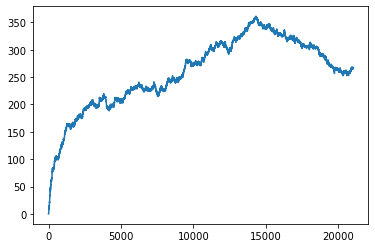

In [45]:
import matplotlib.pyplot as plt
from uplift.metrics import qini_curve
x , y = qini_curve(target_valid, pred, treatment_valid)
plt.plot(x,y)

# Трансформация классов

In [23]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 9, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 9],
 'subsample': [0.4, 0.7, 1.0]}


In [24]:
from uplift.models import ClassTransformation
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)

best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )
#     sm = OneModel(clf_)


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val = train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] // 2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_.set_params(**seting)
           
            transf = ClassTransformation(clf_)
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break
                
            transf = transf.fit(x_train,y_train,treatment_train)
            pred = transf.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10538695.05081296
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 16240096.243842699
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 17899978.490104116
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 19389470.46260696
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 20372852.32125759
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 20650615.848158948
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 21019267.75936257
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 21703311.75227771
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 22110862.02629716
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}

{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 21250020.13044233
[ 362 ]
earlystopping finish, best iteration 272
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 16204172.771545589
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 22488620.26267898
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 22703487.234498337
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 24190502.378791444
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 24391015.487456106
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 24505866.421498217
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 25212506.027616195
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 24310994.76025308
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 24240606.2432876
[ 272 ]
{'colsample_bytree':

{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 20559708.834451325
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 20495463.71500632
[ 212 ]
earlystopping finish, best iteration 122
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 18333208.637986377
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 20853402.960697316
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 20661919.191896208
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 21892492.033295304
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 21916949.257662058
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 22586777.688792042
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 23019124.518038534
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 23481600.450546198
[ 242 ]
{'colsample_bytr

start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 9254174.38141562
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 19055451.81680157
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 17413579.775211394
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 19425258.555923596
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 19905670.722837947
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 20245983.778050043
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 19397253.995424345
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 18866492.62898636
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 19497039.507124484
[ 272 ]
earlystopping finish, best iteration 182
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 18905335.48859086
[

start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 10538695.05081296
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 15877803.157089308
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 19169509.145240173
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 19589020.83210823
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 20210110.744151838
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 21192616.272284016
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 21778272.370299876
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 22243668.017034054
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 22819159.389302358
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 22932224.523850925
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0

{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 23301008.663323976
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 24673248.279800393
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 24584032.950014316
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 24524401.12554445
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 24151977.311408363
[ 242 ]
earlystopping finish, best iteration 152
iteration 18  with params {'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 17429248.92043733
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 18814623.27303227
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 19500119.143013775
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 20294096.51459191
[ 122 ]
{'colsample_bytree': 0.7,

{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 17795642.790588856
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 16893352.476344295
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 19611842.91972398
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 19883193.18466165
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 20315976.626682743
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 20225585.523769677
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 19988554.358569227
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 19847194.63875673
[ 272 ]
earlystopping finish, best iteration 182
iteration 22  with params {'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.7} auqc 14856746.60440427
[ 32 ]
{'colsample_bytree': 0.7,

{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 18094175.898887984
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 19082850.131051287
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 19825458.66311217
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 20737127.09331855
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 21944677.023644507
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 22690472.292948604
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 23072596.65431647
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 23128224.16937483
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 23413093.55807721
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 23507203.258757353
[ 362 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 23510767.729298666
[ 

{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 20112734.267316543
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 20445585.824777544
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 20144305.175034203
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 20329809.87349575
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 20390475.351038948
[ 332 ]
earlystopping finish, best iteration 242
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 15406111.687540703
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 17699382.347159483
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 17257356.641003408
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 21979320.400275312
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 23608644.650240712
[ 152 ]
{'colsample_bytr

{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 20603445.286960676
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 20408805.35457448
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 20077142.69171807
[ 302 ]
earlystopping finish, best iteration 212
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 11332792.359326735
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 15146762.600292094
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 16967205.73320081
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 18738906.16677534
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 19275484.169002175
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 18725499.0758157
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 19646196.619737
[ 212 ]
{'colsample_bytree': 1.0

start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 10797759.209952489
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 14857844.496014804
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 15873107.457334206
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 16527022.07927338
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 18351736.022012793
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 18349409.973896533
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 18981994.839881837
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 19723099.609482586
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 19917666.00424345
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 20245965.301001586
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0

In [40]:
from uplift.models import ClassTransformation
from uplift.metrics import uplift_at_k,qini_auc_score

lr = 0.01
RANDOM_STATE = 12
clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**2 -1,
        max_depth=2,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=300,
        subsample=0.4,
        colsample_bytree = 1.0
)
transf = ClassTransformation(clf_)

transf = transf.fit(X_learn, target_learn, treatment_learn)
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = transf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank c

Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Число замеров 100
AUQC: mean:  2564141.182535214 | std:  333523.6329919626
uplift30%: mean:  0.08114811331829154 | std:  0.009805022292362917
Kendall_rank_correlation: mean:  0.5804444444444444 | std:  0.1434013967630379
AUUC: mean:  0.03935293753760177 | std:  0.005264144352381771


In [38]:
from uplift.models import ClassTransformation
from uplift.metrics import uplift_at_k,qini_auc_score

lr = 0.01
RANDOM_STATE = 12
clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**2 -1,
        max_depth=2,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=392,
        subsample=0.4,
        colsample_bytree = 1.0
)
transf = ClassTransformation(clf_)

transf = transf.fit(X_learn, target_learn, treatment_learn)
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = transf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.64444444444

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  2494143.8865438187 | std:  331990.00992912403
uplift30%: mean:  0.07990167869897782 | std:  0.009996035422514614
Kendall_rank_correlation: mean:  0.5657777777777777 | std:  0.14038302937686079
AUUC: mean:  0.03833594068942364 | std:  0.005260616863589698


# Две независимые модели

In [7]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 9, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 9],
 'subsample': [0.4, 0.7, 1.0]}


In [50]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc_two = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc_two = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)


lr = 0.01
RANDOM_STATE = 12

best_auqc = 0.0
for j, params_t in enumerate(grid_list):
    print("iteration", j," with params", params_t)
    
    clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )
    
    
    clf_c = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )




    auqc_res= []

    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val = train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] // 2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values

        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):

            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_t.set_params(**seting)
            clf_c.set_params(**seting)

            two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_independent')

            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break

            two.fit(x_train,y_train,treatment_train)
            pred = two.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)


            print(params_t, 'auqc',auqc)

            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1

        auqc_res.append(best)   

    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc_two[j] = mid
        best_param_auqc[j] = [params_t,params_c]
        print("iteration {}, auqc {}, params {}".format(j, mid, [params_t,params_c]))
        best_auqc = mid

    
    


(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2912744.578085363
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 4451593.2464544475
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 3917601.023763582
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2699927.6282362267
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 3326617.8270450383
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 3588628.952013567
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 518057.55719394237
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 301029.70995093137
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 118655.07383466512


start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 8394119.240155794
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 8492626.35153108
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 7652233.364073291
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 6916829.569431543
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 7567686.240370773
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 3304251.948418729
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 3937352.9752196595
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 4724651.798663519
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 5166123.5451442525
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 7008264.895335652
[ 152 ]
{

{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 16377967.702085823
[ 362 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 16437953.154393747
[ 392 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 16622681.395119093
[ 422 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 16881075.890842326
[ 452 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 17020495.34117645
[ 482 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 17610574.844915822
[ 512 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 17957565.358493797
[ 542 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 18124484.173478097
[ 572 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 18217580.6058044
[ 602 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 18349724.155576006
[ 632 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 18636199.945428595

start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 6455167.590881981
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 10672772.857448637
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 9576841.128719851
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 9684274.52963829
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 11424984.329556376
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 12379376.822824888
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 13596494.846301086
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 14489451.107220948
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 14812423.918683283
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 15009556.394786596
[ 302 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} 

{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15870961.743251793
[ 422 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15926291.853148088
[ 452 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15825650.145280242
[ 482 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15475117.148563601
[ 512 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 15113022.813906796
[ 542 ]
earlystopping finish, best iteration 452
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 3607686.4420654178
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 9019663.319202013
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 7870652.0155764595
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 10944375.597061388
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 1.0} auqc 13693854.083666064
[ 152 ]
{'colsample_bytr

{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 2555230.3537111655
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 1034791.202302739
[ 152 ]
earlystopping finish, best iteration 62
iteration 18  with params {'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 9045407.168213658
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 8829831.588914149
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 8498111.12461149
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 8829702.229224823
[ 122 ]
earlystopping finish, best iteration 32
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc -272901.29688764364
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 2841313.5366022736
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample':

{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 12236198.694213264
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 12176423.087949693
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 12003976.70423887
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 12422498.56785699
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 13618085.523316272
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 14023067.855599016
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 14430014.17215991
[ 332 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 14995764.584079206
[ 362 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 15148206.104998827
[ 392 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 14925217.35257858
[ 422 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 14956907.024870813


{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 5366486.732969396
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 5620869.486283958
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 5716952.530984469
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 7898764.985682853
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 9149374.326461121
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 10641698.88555213
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 11263577.665323868
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 11864057.012388565
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 13585304.693975113
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 14067744.504511736
[ 332 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 1.0} auqc 13895630.736898541
[ 36

{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 1840785.3799986914
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 5387838.384599142
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 5775452.154640794
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 8039140.103382744
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 11029969.59544316
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 12160795.268676221
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 13127150.613833264
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 13366392.55427657
[ 362 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 13683109.688521974
[ 392 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 13288579.80743973
[ 422 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 13421871.398983903
[ 

{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 12704087.7619586
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 12936037.484548792
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 13639845.576825708
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 13933955.904305644
[ 362 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 14023633.675484404
[ 392 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 14267799.856615745
[ 422 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 13998533.453411944
[ 452 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 14122330.705218412
[ 482 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 14319097.797761597
[ 512 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 14737156.583289921
[ 542 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 14951780.50607839

{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12174829.454214
[ 422 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12023085.537422873
[ 452 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12293670.434559561
[ 482 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12193968.929612733
[ 512 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12408303.64102441
[ 542 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12570074.41849909
[ 572 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12806769.917488538
[ 602 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12798020.501408823
[ 632 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12854567.03485667
[ 662 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12990262.083883189
[ 692 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 12844866.004032701
[ 

{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 11405308.85777536
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 10901774.445375815
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 10505776.65692047
[ 242 ]
earlystopping finish, best iteration 152
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc -132245.18745645136
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 2453118.62838766
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 4239816.645399816
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 4874024.155299589
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 6431040.335550189
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 7190387.172494255
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 8676595.359511383
[ 212 ]
{'colsample_bytree': 1.

In [51]:
print("best accuracies in folds:")
print(accuracy_auqc_two)
print(best_param_auqc)

best accuracies in folds:
{0: 4020111.0992340073, 3: 12261758.297605384, 6: 17315126.223856274}
{0: [{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}], 3: [{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}], 6: [{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}]}


In [10]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score

lr = 0.01
RANDOM_STATE = 12
max_depth = 6
colsample_bytree = 0.4
subsample = 0.4
n_est = 752

clf_t = LGBMClassifier(
        boosting_type='gbdt',
        n_estimators= n_est,
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)

clf_c = LGBMClassifier(
        boosting_type='gbdt',
        n_estimators=n_est,
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)

two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_independent')

two = two.fit(X_learn, target_learn, treatment_learn)
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  

Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Число замеров 100
AUQC: mean:  1850246.1717833623 | std:  342090.90671718895
uplift30%: mean:  0.07599331648522346 | std:  0.011015159109000501
Kendall_rank_correlation: mean:  0.5257777777777778 | std:  0.159442225178813
AUUC: mean:  0.02891418055578219 | std:  0.005586865186990442


# Две зависимые T C

In [54]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc_two = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc_two = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)


lr = 0.01
RANDOM_STATE = 12

best_auqc = 0.0
for j, params_t in enumerate(grid_list):
    print("iteration", j," with params", params_t)
    
    clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )
    
    
    clf_c = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )




    auqc_res= []

    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val = train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] // 2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values

        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):

            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_t.set_params(**seting)
            clf_c.set_params(**seting)

            two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_treatment')

            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break

            two.fit(x_train,y_train,treatment_train)
            pred = two.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)


            print(params_t, 'auqc',auqc)

            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1

        auqc_res.append(best)   

    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc_two[j] = mid
        best_param_auqc_two[j] = [params_t,params_c]
        print("iteration {}, auqc {}, params {}".format(j, mid, [params_t,params_c]))
        best_auqc = mid

    
    


(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2348479.15846429
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 4112129.9994337037
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 3536049.524862863
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2236700.2633414567
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 4015090.445139475
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 6185276.944398351
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2367951.196468346
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2548748.540892251
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2302805.3737514615
[ 12

{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 9708583.96351339
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 9866780.44009588
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 11719974.83236146
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 12457318.482732013
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 11074201.146026284
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 12277385.803026825
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 12487437.331744894
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 12585290.549304798
[ 302 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 14056511.788016096
[ 332 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 14992519.636420488
[ 362 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 14497656.591838129
[ 

start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 5448486.259525709
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 11170372.15719086
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 11103146.62243624
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 10836892.119749025
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 10470991.035650566
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc -2335132.6771534756
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 3451195.1691136137
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 7763389.245589085
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 8853321.929288007
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 10043937.347794421
[ 15

{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 7034427.329760708
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 1100135.0811248794
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 6222346.8707546
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 3258522.4522095993
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 505774.60498321056
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 5589071.90436215
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 7672042.274008945
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 3548251.2584278584
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 5273758.555571079
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 8187890.286009483
[ 182 ]
{'colsample_bytree': 0.7, '

{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 9295470.687624604
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 11150816.500763461
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 10377396.245684937
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 8553860.646571726
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 10388729.490339004
[ 212 ]
earlystopping finish, best iteration 122
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 2184845.9274472
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 3662477.721316293
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 1434791.8686186299
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 6986767.360653631
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 7951182.864555515
[ 152 ]
{'colsample_bytree': 0.7

start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 2854053.072396137
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 680144.5756427869
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 270300.31130957603
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc -82496.44348544627
[ 122 ]
earlystopping finish, best iteration 32
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 8753097.560087629
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 7432950.575087793
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 4706930.376227081
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 3326997.630310312
[ 122 ]
earlystopping finish, best iteration 32
iteration 27  with params {'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'ma

start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 8009906.520230442
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 4566405.432248533
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 7039952.832776688
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 3498784.408657849
[ 122 ]
earlystopping finish, best iteration 32
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 1339672.0269681066
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 4545290.676443562
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 6371186.833729081
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 5534746.770670094
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 5987182.866373703
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 6758895.28053578
[ 182 ]
{'

In [55]:
print(best_param_auqc_two)
print(accuracy_auqc_two)

{0: [{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}], 3: [{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}], 6: [{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}]}
{0: 5148703.471916027, 3: 9615884.97580532, 6: 12029543.65037305}


In [19]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score

lr = 0.01
RANDOM_STATE = 12
max_depth = 6
colsample_bytree = 0.4
subsample = 0.4
n_est = 332

clf_t = LGBMClassifier(
        boosting_type='gbdt',
        n_estimators= n_est,
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)

clf_c = LGBMClassifier(
        boosting_type='gbdt',
        n_estimators=n_est,
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)

two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_treatment')

two = two.fit(X_learn, target_learn, treatment_learn)
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank co

Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Число замеров 100
AUQC: mean:  1171584.81131448 | std:  337536.977351759
uplift30%: mean:  0.06013084166549709 | std:  0.010163797067152426
Kendall_rank_correlation: mean:  0.4422222222222223 | std:  0.17871526104878988
AUUC: mean:  0.01916402559729035 | std:  0.005581938482544539


# Две зависимые С, T

In [56]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc_ct = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc_ct = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)


lr = 0.01
RANDOM_STATE = 12

best_auqc = 0.0
for j, params_t in enumerate(grid_list):
    print("iteration", j," with params", params_t)
    
    clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )
    
    
    clf_c = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )




    auqc_res= []

    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val = train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] // 2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values

        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):

            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_t.set_params(**seting)
            clf_c.set_params(**seting)

            two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_control')

            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break

            two.fit(x_train,y_train,treatment_train)
            pred = two.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)


            print(params_t, 'auqc',auqc)

            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1

        auqc_res.append(best)   

    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc_ct[j] = mid
        best_param_auqc_ct[j] = [params_t,params_c]
        print("iteration {}, auqc {}, params {}".format(j, mid, [params_t,params_c]))
        best_auqc = mid

    
    


(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2801565.332042232
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2888194.9889477566
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2702408.4164882973
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 1694173.4937476143
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 4318516.650502816
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 2452320.0588018596
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 3051245.1567330062
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 3738222.2374041826
[ 242 ]
earlystopping finish, best iteration 152
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 5874317.522220

{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 14403624.985505149
[ 572 ]
earlystopping finish, best iteration 482
iteration 3, auqc 18019597.50402415, params [{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}]
iteration 4  with params {'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 5320657.173607372
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 7113034.558073111
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 6781371.899319775
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 6483574.991971791
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 7450484.368155554
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 7676234.799852259
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'su

{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 15131041.092472203
[ 422 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 14925992.125412412
[ 452 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 15138687.018374078
[ 482 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 14333215.697314315
[ 512 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 14925395.912074126
[ 542 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 14403624.985505149
[ 572 ]
earlystopping finish, best iteration 482
iteration 6  with params {'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 9106207.123359159
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 9765183.015402287
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 11133938.818783067
[ 92 ]
{'colsample_bytree': 0.4

{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 13799740.050897598
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 14846342.329910226
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 16046479.442537308
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 17432405.997683264
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 17822501.258943327
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 16367315.271638714
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 17363137.57318662
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 18185535.29958009
[ 302 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 18553397.12031673
[ 332 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 17754194.400001198
[ 362 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 19680658.165855967


{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 2598805.2453701794
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 482358.14892899245
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc -438195.7162045017
[ 122 ]
earlystopping finish, best iteration 32
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 8760803.653310515
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc -2182130.2769873366
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc -3974612.153265722
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc -3381119.155641556
[ 122 ]
earlystopping finish, best iteration 32
iteration 13  with params {'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.7} auqc 2801565.332042232
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsampl

{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.7} auqc 16898590.146996282
[ 692 ]
earlystopping finish, best iteration 602
iteration 17  with params {'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 2725438.5644046813
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 8556713.510733888
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 9157932.496343277
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 7370581.090726428
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 8350513.799988173
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 9077157.512266695
[ 182 ]
earlystopping finish, best iteration 92
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc -1389271.6254354492
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsampl

start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 1532200.4944869727
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 9340077.669562452
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 11784426.316778056
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 12120896.429737762
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 13243709.164681204
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 11771978.857876793
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 13608430.109430656
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 12070089.922520243
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 13714580.2229577
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4} auqc 12559940.060761668
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 9, 'subsample': 0.4}

{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc -5499305.096668154
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc -3561228.59330865
[ 122 ]
earlystopping finish, best iteration 32
iteration 27  with params {'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 4474640.417307667
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 9263187.162820742
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 8148864.079777308
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 5747925.432231188
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 5944386.109648004
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc -2510866.249907106
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 

start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 3142306.532552354
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 9909515.831637748
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 8593383.975020118
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 11867852.535276838
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 9955417.203570575
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 11440907.168703884
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 12254462.952572212
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 12681166.413773328
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 15035988.281685725
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 14996906.723189183
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} 

{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 10222154.66310706
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 12401682.63024903
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 13064323.383114643
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 13295317.67825646
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 14230193.692714088
[ 362 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 13008816.008154295
[ 392 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 12973189.594095662
[ 422 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.7} auqc 13816699.126853392
[ 452 ]
earlystopping finish, best iteration 362
iteration 35  with params {'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 1.0} auqc 4046307.3901848197
[ 32 ]
{'colsample_bytree': 1

In [57]:
print(accuracy_auqc_ct)
print(best_param_auqc_ct)

{0: 5096417.086361501, 3: 18019597.50402415, 9: 18141655.860706545, 30: 18225830.185253717}
{0: [{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}], 3: [{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}], 9: [{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}], 30: [{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.4}, {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}]}


In [20]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score

lr = 0.01
RANDOM_STATE = 12
max_depth = 6
colsample_bytree = 1.0
subsample = 0.4
n_est = 332

clf_t = LGBMClassifier(
        boosting_type='gbdt',
        n_estimators= n_est,
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)

clf_c = LGBMClassifier(
        boosting_type='gbdt',
        n_estimators=n_est,
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)

two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_control')

two = two.fit(X_learn, target_learn, treatment_learn)
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Число замеров 100
AUQC: mean:  1607664.7569734368 | std:  346783.1736792103
uplift30%: mean:  0.07011222960709268 | std:  0.010596848340966745
Kendall_rank_correlation: mean:  0.3280000000000001 | std:  0.18092390123242902
AUUC: mean:  0.024662066638348353 | std:  0.005503800578511332


# Uplift деревья

In [25]:
criterions = ["uplift_gini"]
min_samples_leaf =  [int(x) for x in np.linspace(100, 100000, num = 20)]
stat_param=[40.0]
max_features = [0.3,0.6,1.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'max_features':max_features


}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)

{'criterion': ['uplift_gini'],
 'max_features': [0.3, 0.6, 1.0],
 'min_samples_leaf': [100,
                      5357,
                      10615,
                      15873,
                      21131,
                      26389,
                      31647,
                      36905,
                      42163,
                      47421,
                      52678,
                      57936,
                      63194,
                      68452,
                      73710,
                      78968,
                      84226,
                      89484,
                      94742,
                      100000]}


In [26]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)

best_auqc = 0.0

RANDOM_STATE = 12

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ =RandomForestClassifier(n_estimators = 30, min_samples_leaf = params['min_samples_leaf'], 
        max_features = params['max_features'], max_depth = None, criterion=params['criterion'], random_state=RANDOM_STATE)



    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val = train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] // 2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values
        
                     
                
        clf_.fit(x_train,y_train,treatment_train)
        pred = clf_.predict_uplift(x_val)

        auqc = qini_auc_score(y_val, pred, treatment_val)


        print(params, 'auqc', auqc)
            
            
                
        auqc_res.append(auqc)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
iteration 0  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 100}
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 100} auqc 11773670.454658672
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 100} auqc 14630463.556079231
iteration 0, auqc 13202067.005368952, params [{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 100}]
iteration 1  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 5357}
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 5357} auqc 8446689.191722617
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 5357} auqc 9053605.85548488
iteration 2  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 10615}
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 10615} auqc 6866070.318088584
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 

{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 42163} auqc 0.0
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 42163} auqc 0.0
iteration 29  with params {'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 47421}
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 47421} auqc 0.0
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 47421} auqc 0.0
iteration 30  with params {'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 52678}
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 52678} auqc 0.0
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 52678} auqc 0.0
iteration 31  with params {'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 57936}
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 57936} auqc 0.0
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 57936} auqc 0.0
ite

{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 89484} auqc 0.0
iteration 58  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 94742}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 94742} auqc 0.0
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 94742} auqc 0.0
iteration 59  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 100000}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 100000} auqc 0.0
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 100000} auqc 0.0
best accuracies in folds:
{0: 13202067.005368952, 20: 14862091.16324168}
{0: [{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 100}], 20: [{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 100}]}


In [33]:
criterions = ["uplift_gini"]
min_samples_leaf =  [int(x) for x in np.linspace(1000, 10000, num = 10)]
max_features = [0.3,0.6,1.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'max_features':max_features


}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)

{'criterion': ['uplift_gini'],
 'max_features': [0.3, 0.6, 1.0],
 'min_samples_leaf': [1000,
                      2000,
                      3000,
                      4000,
                      5000,
                      6000,
                      7000,
                      8000,
                      9000,
                      10000]}


In [34]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)

best_auqc = 0.0

RANDOM_STATE = 12

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ =RandomForestClassifier(n_estimators = 30, min_samples_leaf = params['min_samples_leaf'], 
        max_features = params['max_features'], max_depth = None, criterion=params['criterion'], random_state=RANDOM_STATE)



    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val = train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] // 2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values
        
                     
                
        clf_.fit(x_train,y_train,treatment_train)
        pred = clf_.predict_uplift(x_val)

        auqc = qini_auc_score(y_val, pred, treatment_val)


        print(params, 'auqc', auqc)
            
            
                
        auqc_res.append(auqc)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
iteration 0  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 1000}
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 1000} auqc 15646363.788732633
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 1000} auqc 22762184.01516094
iteration 0, auqc 19204273.901946787, params [{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 1000}]
iteration 1  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 2000}
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 2000} auqc 16165938.816947974
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 2000} auqc 22640601.445144758
iteration 1, auqc 19403270.131046366, params [{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 2000}]
iteration 2  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 3000}
{'criterion': 'uplift_gini', 'max_features

{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 7000} auqc 4394008.830053642
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 7000} auqc 6198314.223429039
iteration 27  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 8000}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 8000} auqc 4355317.990960166
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 8000} auqc 9511747.817052908
iteration 28  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 9000}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 9000} auqc 5138663.9181063175
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 9000} auqc 9217405.482156731
iteration 29  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 10000}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 10000} auqc 5276416.46363617

In [35]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import uplift_at_k,qini_auc_score

import warnings
warnings.filterwarnings("ignore")
lr = 0.01
RANDOM_STATE = 12

min_samples_leaf = 2000
criterion = 'uplift_gini'
max_features = 0.6

clf_tree = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterion, random_state = RANDOM_STATE)


clf_tree = clf_tree.fit(X_learn, target_learn, treatment_learn)
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = clf_tree.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Число замеров 100
AUQC: mean:  2295968.7283106414 | std:  317898.859483691
uplift30%: mean:  0.07550073720447177 | std:  0.009816745276706444
Kendall_rank_correlation: mean:  0.508888888888889 | std:  0.15606777939267016
AUUC: mean:  0.035306555075294496 | std:  0.0050486786274471975


# uplift деревья со стат тестом


In [30]:
criterions = ["stat_test"]
min_samples_leaf =  [int(x) for x in np.linspace(1000, 10000, num = 10)]
stat_param=[40.0]
max_features = [0.3,0.6,1.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'max_features':max_features


}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)

{'criterion': ['stat_test'],
 'max_features': [0.3, 0.6, 1.0],
 'min_samples_leaf': [1000,
                      2000,
                      3000,
                      4000,
                      5000,
                      6000,
                      7000,
                      8000,
                      9000,
                      10000]}


In [31]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)

best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ =RandomForestClassifier(n_estimators = 30, min_samples_leaf = params['min_samples_leaf'], 
        max_features = params['max_features'], max_depth = None, criterion=params['criterion'], random_state = RANDOM_STATE)
#     sm = OneModel(clf_)


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val = train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] // 2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values
        
                     
                
        clf_.fit(x_train,y_train,treatment_train)
        pred = clf_.predict_uplift(x_val)

        auqc = qini_auc_score(y_val, pred, treatment_val)


        print(params, 'auqc',auqc)
            
            
                
        auqc_res.append(auqc)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
iteration 0  with params {'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 1000}
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 1000} auqc 11338472.683494404
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 1000} auqc 13804316.997124508
iteration 0, auqc 12571394.840309456, params [{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 1000}]
iteration 1  with params {'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 2000}
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 2000} auqc 11866284.575871274
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 2000} auqc 14757144.854348056
iteration 1, auqc 13311714.715109665, params [{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 2000}]
iteration 2  with params {'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 3000}
{'criterion': 'stat_test', 'max_features': 0.3, 'min_sample

{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 7000} auqc 5910875.085637234
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 7000} auqc 6185279.757350452
iteration 27  with params {'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 8000}
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 8000} auqc 5668555.535338424
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 8000} auqc 7179508.279145472
iteration 28  with params {'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 9000}
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 9000} auqc 5176620.1287378
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 9000} auqc 6962551.152493931
iteration 29  with params {'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 10000}
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 10000} auqc 5296758.420044199
{'criterion': 'stat_t

In [36]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import uplift_at_k,qini_auc_score

import warnings
warnings.filterwarnings("ignore")
lr = 0.01
RANDOM_STATE = 12

min_samples_leaf = 1000
criterion = 'stat_test'
max_features = 0.6

clf_tree = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterion,random_state = RANDOM_STATE)


clf_tree = clf_tree.fit(X_learn, target_learn, treatment_learn)
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = clf_tree.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank 

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Число замеров 100
AUQC: mean:  1688934.5619851365 | std:  292789.40625990153
uplift30%: mean:  0.06322967969546686 | std:  0.009530789072782998
Kendall_rank_correlation: mean:  0.6155555555555555 | std:  0.1292104815686421
AUUC: mean:  0.027143479500376846 | std:  0.004734005345713636


# Регрессия транфсформация классов mse

In [6]:
p = train[train.treatment_flg == 1].shape[0] / train.shape[0]

print("уровень воздействий в train:", p)
print('\n')

# train['target_class'] = train['target'] * (train['treatment_flg'] - p)/(p * (1 - p))

train['target_class'] = 0
train.loc[(train.treatment_flg == 1) & (train.target == 1),'target_class'] = 2 

train.loc[(train.treatment_flg == 0) & (train.target == 1), 'target_class'] = -2 
print(train)      

уровень воздействий в train: 0.4998125328067588


            treatment_flg  target  target_class
client_id                                      
000012768d              0       1            -2
000036f903              1       1             2
00010925a5              1       1             2
0001f552b0              1       1             2
00020e7b18              1       1             2
000220a0a7              0       1            -2
00022fd34f              1       1             2
0002ce2217              0       1            -2
00031cbbe6              0       1            -2
00035a21d9              0       0             0
00038f9200              1       1             2
0004231e2a              1       0             0
0004254599              0       0             0
00042a927a              0       1            -2
0004315e57              0       1            -2
00047b3720              1       0             0
0004e1e14e              0       0             0
00065f11c7              0       1     

In [7]:
indices_train = train.index
indices_test = test.index

RANDOM_STATE = 12
X_labeled = features.loc[indices_train, :]
treatment_labeled = train.loc[indices_train, 'treatment_flg']
target_labeled = train.loc[indices_train, 'target']
regression_y_labeled = train.loc[indices_train, 'target_class']

X_labeled = X_labeled.replace([np.inf, -np.inf], np.nan).fillna(0)

indices_learn, indices_valid = train_test_split(
        train.index,
        test_size=0.3,
        random_state=RANDOM_STATE + 1,
)

# indices_learn, indices_eval = train_test_split(
#         train.index,
#         test_size=0.4,
#         random_state=RANDOM_STATE + 1,
# )


X_learn = X_labeled.loc[indices_learn, :].values
treatment_learn = treatment_labeled.loc[indices_learn].values
target_learn = target_labeled.loc[indices_learn].values
y_regression_learn = regression_y_labeled.loc[indices_learn].values

# X_eval = X_labeled.loc[indices_eval, :].values
# treatment_eval = treatment_labeled.loc[indices_eval].values
# target_eval = target_labeled.loc[indices_eval].values
# y_regression_eval = regression_y_labeled.loc[indices_eval].values

X_valid = X_labeled.loc[indices_valid, :].values
treatment_valid = treatment_labeled.loc[indices_valid].values
target_valid = target_labeled.loc[indices_valid].values
y_regression_valid = regression_y_labeled.loc[indices_valid].values

# X_test = features.loc[indices_test, :]

In [16]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 9, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
# subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
subsample = [1.0]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 9],
 'subsample': [1.0]}


In [17]:
from uplift.models import OneModel
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier,LGBMRegressor

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_learn, num_folds)
#cross validation
print(indices_learn.shape)


lr = 0.01
RANDOM_STATE = 12
best_auqc = 0.0
for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_reg= LGBMRegressor(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='regression',
            metric = 'mse',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )
    


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = features.loc[indices_all_folds[i]].values
        y_val = train.loc[indices_all_folds[i],'target'].values
        treatment_val = train.loc[indices_all_folds[i],'treatment_flg'].values
        z_val = train.loc[indices_all_folds[i],'target_class'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_learn.shape[0] // 2)

        x_train = features.loc[united].values
        y_train = train.loc[united, 'target'].values
        treatment_train = train.loc[united, 'treatment_flg'].values
        z_train = train.loc[united, 'target_class'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_reg.set_params(**seting)
           
                        
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break
                
            clf_reg = clf_reg.fit(x_train,z_train)
            pred = clf_reg.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 20946904.95392838
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 23683808.850688897
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 22802150.43895629
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 22176400.585126594
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 22113333.726883546
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 6291794.432160623
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 16879171.866567753
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 16904323.30207765
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 1.0} auqc 17792327.360440753
[

{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 6291794.432160623
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 19228158.875133954
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 16795911.045072325
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 17968907.59905552
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 16197514.036234692
[ 152 ]
earlystopping finish, best iteration 62
iteration 5  with params {'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 18447641.21932225
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 19139061.225363836
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 18595369.751356266
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 17193077.009915106
[ 122 ]
{'colsample_bytree': 0.7, 'ma

{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 15652168.128930904
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 15686212.329796292
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 15427643.647166066
[ 122 ]
earlystopping finish, best iteration 32
iteration 10  with params {'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 10074895.36825297
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 13370305.131741032
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 12840523.11493995
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 12919570.62509793
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 12997969.422741182
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample

In [20]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


lr=0.01
RANDOM_STATE = 12
max_depth = 2
colsample_bytree = 1.0
subsample=0.4
n_estimators = 182

clf_reg= LGBMRegressor(
            boosting_type='gbdt',
            num_leaves=2**max_depth -1,
            n_estimators = n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='regression',
            metric = 'mse',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )

clf_reg = clf_reg.fit(X_learn,y_regression_learn)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = clf_reg.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank co

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Число замеров 100
AUQC: mean:  2151898.5102788857 | std:  328862.1023664158
uplift30%: mean:  0.07213087675775212 | std:  0.009228877657505446
Kendall_rank_correlation: mean:  0.404888888888889 | std:  0.16423075872832973
AUUC: mean:  0.03264883309118337 | std:  0.005200799976149716
